In [ ]:
#Importing Packages
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.layers as L
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns


import numpy as np
import pandas as pd

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import re

In [ ]:
#Loading Data
train_df = pd.read_csv('/content/Corona_NLP_train.csv',encoding='latin1')
test_df = pd.read_csv('/content/Corona_NLP_test.csv',encoding='latin1')


In [ ]:
train_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
print('Tweet in train data:',len(train_df))
print('Tweet in test data:',len(test_df))

Tweet in train data: 41157
Tweet in test data: 3798


In [ ]:
#Handling Missing Values
train_df.isnull().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [ ]:
train_dist=train_df['Sentiment'].value_counts()

In [ ]:
test_df['Sentiment'].value_counts()

Negative              1041
Positive               947
Neutral                619
Extremely Positive     599
Extremely Negative     592
Name: Sentiment, dtype: int64

<Axes: xlabel='Sentiment', ylabel='Sentiment'>

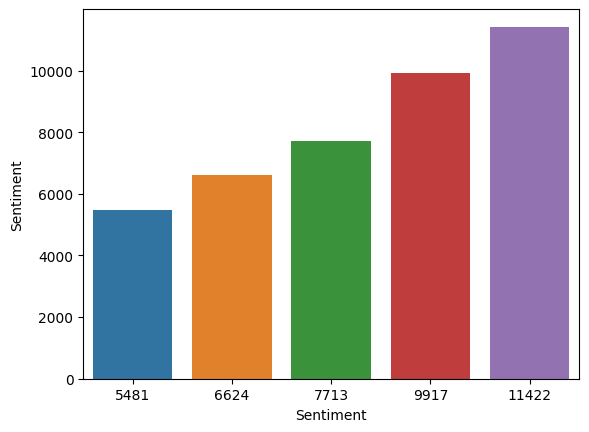

In [ ]:
sns.barplot(x = train_dist.index,y = train_dist,data=train_dist)

In [ ]:
def text_process(tweet):
    tweet = re.sub(r'http\S+', ' ', tweet)
    tweet = re.sub(r'<.*?>',' ', tweet)
    tweet = re.sub(r'\d+',' ', tweet)
    tweet = re.sub(r'#\w+',' ', tweet)
    tweet = re.sub(r'@\w+',' ', tweet)
    tweet = tweet.split()
    tweet = " ".join([word for word in tweet if not word in stop_words])
    return tweet

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop_words = stopwords.words('english')


In [ ]:
train_data=train_df['OriginalTweet'].apply(lambda x:text_process(x))
test_data=test_df['OriginalTweet'].apply(lambda x:text_process(x))

286

In [ ]:
def get_num_words_per_sample(sample_texts):
    """Returns the median number of words per sample given corpus.

    # Arguments
        sample_texts: list, sample texts.

    # Returns
        int, median number of words per sample.
    """
    num_words = [len(s.split()) for s in sample_texts]
    return np.median(num_words)
print('the number of samples/number of words per sample ratio:',len(train_data)/get_num_words_per_sample(train_data))

the number of samples/number of words per sample ratio: 2286.5


In [ ]:
#Tokenize the Tweet
vocab_size = 20000
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
MAX_SEQUENCE_LENGTH = 500

max_length =len(max(train_data,key=len))
if max_length > MAX_SEQUENCE_LENGTH:
  max_length = MAX_SEQUENCE_LENGTH

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Generate the word index dictionary
tokenizer.fit_on_texts(train_data)
word_index = tokenizer.word_index

# Generate and pad the training sequences
training_sequences = tokenizer.texts_to_sequences(train_data)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Generate and pad the testing sequences
testing_sequences = tokenizer.texts_to_sequences(test_data)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)


In [ ]:
labels={
            'Extremely Negative': 0,
            'Negative': 0,
            'Neutral': 1,
            'Positive':2,
            'Extremely Positive': 2
        }

train_df['Sentiment']=train_df['Sentiment'].map(labels)
test_df['Sentiment']=test_df['Sentiment'].map(labels)
training_labels = np.array(train_df['Sentiment'])
testing_labels = np.array(test_df['Sentiment'])

In [ ]:
embedding_dim = 16
lstm_dim = 32
dense_dim = 24

model=tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(3)
])

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 286, 16)           320000    
                                                                 
 bidirectional (Bidirection  (None, 64)                12544     
 al)                                                             
                                                                 
 dense (Dense)               (None, 24)                1560      
                                                                 
 dense_1 (Dense)             (None, 3)                 75        
                                                                 
Total params: 334179 (1.27 MB)
Trainable params: 334179 (1.27 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.fit(training_padded,training_labels, epochs=2, validation_split=0.12, batch_size=32)

Epoch 1/2
1132/1132 [==============================] - 250s 219ms/step - loss: 0.7056 - accuracy: 0.6781 - val_loss: 0.4605 - val_accuracy: 0.8295
Epoch 2/2
1132/1132 [==============================] - 247s 218ms/step - loss: 0.3329 - accuracy: 0.8890 - val_loss: 0.3944 - val_accuracy: 0.8611


In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and loss history
plot_graphs(history_lstm, 'accuracy')
plot_graphs(history_lstm, 'loss')

In [ ]:
test_loss, test_acc = model.evaluate(testing_padded,  testing_labels, verbose=2)

print('\nTest accuracy:', test_acc)
print('Test Loss:',test_loss)

119/119 - 6s - loss: 0.4464 - accuracy: 0.8418 - 6s/epoch - 51ms/step

Test accuracy: 0.8417588472366333
Test Loss: 0.44642242789268494


In [ ]:
pred = model.predict(testing_padded)

119/119 [==============================] - 6s 35ms/step


In [ ]:
np.argmax(pred[0])


0